In [1]:
import pandas as pd
import numpy as np
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.model_selection import KFold
from multiprocessing import Process, Manager, SimpleQueue
import multiprocessing
import shutil
from rules import *
from vote import *
from cv import *
from precision import *

root = "./../Classic_threshold_no_constant/"
cv = 3

colors_to_print = ["red",  "blue", "orange",  "violet", "darkgrey", "darkred", "darkblue", "darkorange", "darkviolet", "grey"]

# 1° Load data

In [2]:
data = pd.read_csv("Data/miniloan-decisions-100K.csv")

In [3]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement
0,John Doe,736,113243,783440,162,0.030005,false,70648
1,John Doe,527,224186,1787385,183,0.054819,false,173197
2,John Doe,460,39954,1733494,75,0.055183,false,328563
3,John Doe,751,219998,1350004,72,0.043400,false,255970
4,John Doe,684,72470,1210944,160,0.037772,false,115742
...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928
99996,John Doe,395,184259,1599473,90,0.040564,false,247703
99997,John Doe,674,242620,1099790,260,0.040825,false,76557
99998,John Doe,420,180957,1645870,203,0.049558,false,143897


# Ratios

In [4]:
ratio_names = [("income","yearlyReimbursement"), ("income","loanAmount"), ("loanAmount","rate")]

In [5]:
# Takes two features and will create the ratio f_0/f_1
def create_features_ratio(data):
    if data[data.index[1]] == 0:
        return 2147483647
    return np.round(data[data.index[0]]/data[data.index[1]], decimals=2)

In [6]:
for ratio_name in ratio_names:
    data[f"{ratio_name[0]}/{ratio_name[1]}"] = data[[ratio_name[0], ratio_name[1]]].apply(create_features_ratio, axis=1)

In [7]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement,income/yearlyReimbursement,income/loanAmount,loanAmount/rate
0,John Doe,736,113243,783440,162,0.030005,false,70648,1.60,0.14,26110372.80
1,John Doe,527,224186,1787385,183,0.054819,false,173197,1.29,0.13,32605003.59
2,John Doe,460,39954,1733494,75,0.055183,false,328563,0.12,0.02,31413368.70
3,John Doe,751,219998,1350004,72,0.043400,false,255970,0.86,0.16,31106073.81
4,John Doe,684,72470,1210944,160,0.037772,false,115742,0.63,0.06,32059172.14
...,...,...,...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928,0.48,0.05,31981153.44
99996,John Doe,395,184259,1599473,90,0.040564,false,247703,0.74,0.12,39430859.20
99997,John Doe,674,242620,1099790,260,0.040825,false,76557,3.17,0.22,26938940.88
99998,John Doe,420,180957,1645870,203,0.049558,false,143897,1.26,0.11,33211031.24


# 2° Create the thresholds

Define the thresholds

In [8]:
thresholds = np.arange(0.25,1,0.25) #[0.25, 0.50, 0.75]
thresholds_str = ["-"+(str(int(i*100))) for i in thresholds]

In [9]:
# Takes a dataframe and return the values per percents for each feature
def description_per_thresholds(data, percents):
    thresholds_Dic =  {}
    for column in data.columns:
        serie = data[column]
        thresholds_Dic[column] = serie.quantile(percents)
        
    return pd.DataFrame.from_dict(thresholds_Dic)

In [10]:
columns_to_compare = ['creditScore', 'income', 'loanAmount', 'monthDuration', 'rate', 'yearlyReimbursement', 'income/yearlyReimbursement']

description = description_per_thresholds(data[columns_to_compare], thresholds)

In [11]:
def GTE_prep_df(value, value_to_compare_to):
    return value >= value_to_compare_to

def LTE_prep_df(value, value_to_compare_to):
    return value <= value_to_compare_to

Transform the data from integer values to boolean values corresponding to GTE or LTE with the different percents.

In [12]:
%%time

booleanDF = pd.DataFrame()

for column in columns_to_compare:
    for i, value in enumerate(thresholds):
        booleanDF[column+"-GTE-"+str(int(value*100))] = data[column].map(lambda x : GTE_prep_df(x, description[column].values[i]))
        booleanDF[column+"-LTE-"+str(int(value*100))] = data[column].map(lambda x : LTE_prep_df(x, description[column].values[i]))

CPU times: user 12.1 s, sys: 78.1 ms, total: 12.2 s
Wall time: 12.2 s


In [13]:
booleanDF["approval"] = data["approval"].map({' true': True, ' false': False})
booleanDF

,creditScore-GTE-25,creditScore-LTE-25,creditScore-GTE-50,creditScore-LTE-50,creditScore-GTE-75,creditScore-LTE-75,income-GTE-25,income-LTE-25,income-GTE-50,income-LTE-50,...,yearlyReimbursement-LTE-50,yearlyReimbursement-GTE-75,yearlyReimbursement-LTE-75,income/yearlyReimbursement-GTE-25,income/yearlyReimbursement-LTE-25,income/yearlyReimbursement-GTE-50,income/yearlyReimbursement-LTE-50,income/yearlyReimbursement-GTE-75,income/yearlyReimbursement-LTE-75,approval
0,True,False,True,False,True,False,True,False,False,True,...,True,False,True,True,False,True,False,False,True,False
1,True,False,False,True,False,True,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
2,True,False,False,True,False,True,False,True,False,True,...,False,True,False,False,True,False,True,False,True,False
3,True,False,True,False,True,False,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
4,True,False,True,False,False,True,False,True,False,True,...,False,False,True,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,False,True,False,True,False,True,True,False,False,True,...,False,True,False,False,True,False,True,False,True,False
99996,False,True,False,True,False,True,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
99997,True,False,True,False,False,True,True,False,True,False,...,True,False,True,True,False,True,False,True,False,False
99998,False,True,False,True,False,True,True,False,True,False,...,False,False,True,True,False,False,True,False,True,False


Create the folder where the data will be stored.

In [15]:
if not path.isdir(root):
    os.mkdir(root)
else : 
    shutil.rmtree(root)
    os.mkdir(root)

In [16]:
booleanDF.to_csv(root+"dfSave.csv")

# 3° Save the best data

In [17]:
# Transform an integer id to a string id
def int_to_str_id(idsInt):
    res = chr(97+idsInt%26)
    idsReducted = int(idsInt/26)
    while idsReducted != 0:
        res = chr(97+(idsReducted-1)%26) + res
        idsReducted = int(idsReducted/26)
    return res

# Syntax of Amie data
def syntax(subject, predicate, objectD):
    return f"{subject}\t{predicate}\t{objectD} \n" # Integer id
    #return f"{int_to_str_id(subject)}\t{predicate}\t{objectD} \n" #String id

# Create the text for each feature and finally write it to the file
def formatData(f, idData, data):
    toWrite = ""
    for i in data.index[:-1]:
        toWrite += syntax(idData, i, data.loc[i])
    if data.loc["approval"]:
        toWrite += syntax(idData, "approval-True", True)
    else:
        toWrite += syntax(idData, "approval-False", False)
    f.write(toWrite)

We store the data in the Amie format. 

In [18]:
f = open(root+"Knowledge_Data.tsv", "w")

booleanDF_to_Save = booleanDF
booleanDF_to_Save["approval"] = data["approval"].map({' true': True, ' false': False})

for idData in booleanDF_to_Save.index:
    formatData(f, idData, booleanDF_to_Save.iloc[idData])
    
f.close()

## Save in cross validation

In [19]:
booleanDF_to_Save = booleanDF
booleanDF_to_Save["approval"] = data["approval"].map({' true': True, ' false': False})

kf = KFold(n_splits=cv, shuffle=True, random_state=42)
kf.get_n_splits(booleanDF_to_Save)

cp = 0

for train_index, test_index in kf.split(booleanDF_to_Save):
    
    f = open(root+f"CV_train_{cp}.tsv", "w")

    for idData in train_index:
        formatData(f, idData, booleanDF_to_Save.iloc[idData])

    f.close()
    
    print("Train repartition :\n",booleanDF_to_Save.iloc[train_index]["approval"].value_counts())
    
    f = open(root+f"CV_valid_{cp}.tsv", "w")

    for idData in test_index:
        formatData(f, idData, booleanDF_to_Save.iloc[idData])

    f.close()
    
    f = open(root+f"index_{cp}.tsv", "w")

    f.write(str(train_index[0]))
    for i in range(1,len(train_index)):
        f.write(","+str(train_index[i]))
    f.write("\n")
    f.write(str(test_index[0]))
    for i in range(1,len(test_index)):
        f.write(","+str(test_index[i]))

    f.close()
    
    cp += 1

Train repartition :
 False    52004
True     14662
Name: approval, dtype: int64
Train repartition :
 False    52007
True     14660
Name: approval, dtype: int64
Train repartition :
 False    52081
True     14586
Name: approval, dtype: int64


# 4° Launch Amie

Describe the parameters.

In [2]:
atom_LIST = [2]#, 3]
minc_LIST = [0, 0.4]#, 0.8]
minpcac_LIST = [0, 0.4]#, 0.8]
minhc_LIST = [0, 0.4]#, 0.8]

Launch Amie.

In [3]:
%%capture captured

sep = "-----------------------------"

parameters = []

for i in range(cv):
    for atom in atom_LIST:
        data = f"{root}CV_train_{i}.tsv"
        !java -jar amie3.jar -htr approval-True,approval-False -maxad $atom $data
        parameters.append(f"CV={i}-A={atom}")
        print(sep)

In [4]:
#captured.stdout

Transform the raw output into sets of rules. 

In [5]:
rules_per_cv = {}
cpt = 0
for cv_res in captured.stdout.split(sep)[:-1]:
    rules = set()
    for line in cv_res.split("\n"):
        if (line != "") and (line[0] == "?"):
            dic = {}
            parts = line.split("\t")

            conclusion_raw = parts[0].split("=>")[1].split("  ")
            conclusion_raw[0] = conclusion_raw[0][1:]
            dic["conclusion"] = Atom(conclusion_raw)

            hypotheses_raw = parts[0].split("=>")[0].split("  ")
            hypotheses = []
            for i in range(0, len(hypotheses_raw)-1, 3):
                hypotheses.append(Atom(hypotheses_raw[i:i+3]))
            dic["hypotheses"] = hypotheses


            rules.add(Rule(dic["hypotheses"], dic["conclusion"], parts[1:]))
    rules_per_cv[parameters[cpt]] = rules
    cpt+=1

Retrieve the indexes for each CV.

In [6]:
indexes = retrieve_indexes(root, cv)
df = pd.read_csv(root+"dfSave.csv")

# 5° Precision

In [7]:
%%time

rules_per_para = run_precision(root, indexes, parameters, rules_per_cv)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Process n°0 : Finished
Process n°2 : Finished
Process n°5 : Finished
Process n°7 : Finished
Process n°10 : Finished
Process n°1 : Finished
Process n°9 : Finished
Process n°8 : Finished
Process n°3 : Finished
Process n°11 : Finished
Process n°12 : Finished
Process n°4 : Finished
Process n°6 : Finished
Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : LaunchedProcess n°4 : Launched

Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Process n°0 : Finished
Process n°2 : Finished
Process n°10 : Finished
Process n°5 : Finished
P

### Add parameters

Describe the combinaison of these new parameters.

In [8]:
new_parameters = []
for minc in minc_LIST:
    for minpcac in minpcac_LIST:
        for minhc in minhc_LIST:
            new_parameters.append([("stdConfidence", minc), ("pcaConfidence", minpcac), ("headCoverage", minhc)])
print(new_parameters)

[[('stdConfidence', 0), ('pcaConfidence', 0), ('headCoverage', 0)], [('stdConfidence', 0), ('pcaConfidence', 0), ('headCoverage', 0.4)], [('stdConfidence', 0), ('pcaConfidence', 0.4), ('headCoverage', 0)], [('stdConfidence', 0), ('pcaConfidence', 0.4), ('headCoverage', 0.4)], [('stdConfidence', 0.4), ('pcaConfidence', 0), ('headCoverage', 0)], [('stdConfidence', 0.4), ('pcaConfidence', 0), ('headCoverage', 0.4)], [('stdConfidence', 0.4), ('pcaConfidence', 0.4), ('headCoverage', 0)], [('stdConfidence', 0.4), ('pcaConfidence', 0.4), ('headCoverage', 0.4)]]


Create the DataFrames corresponding to these parameters.

In [9]:
new_dfs = add_parameters(rules_per_para, new_parameters)

Print the precision for each parameters.

<AxesSubplot:>

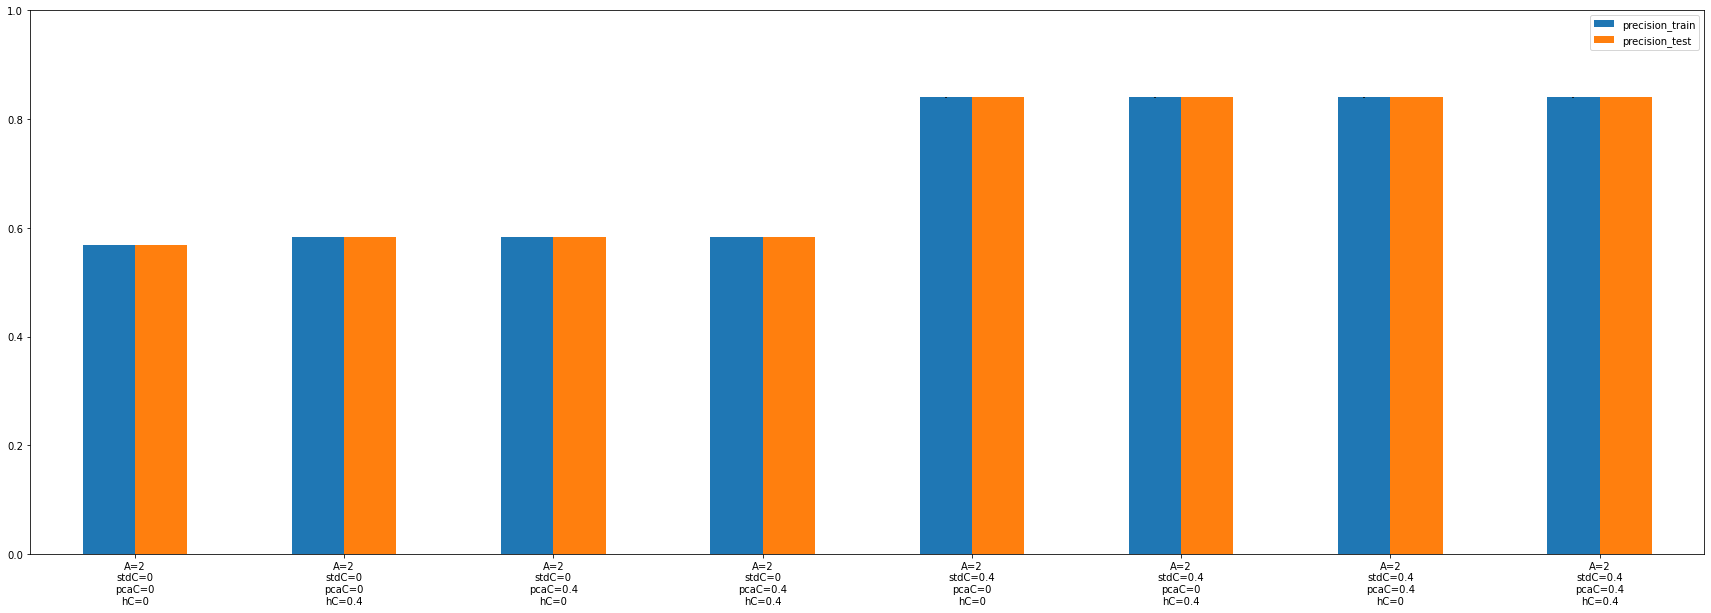

In [10]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 
to_print, to_print_std = mean_and_std_precision(new_dfs, cv)

to_print.plot.bar(ax=_axs, rot=0, yerr=to_print_std, ylim=[0,1])

# 6° Prediction

In [11]:
to_print_save =  []
to_print_std_save = []

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Process n°0 : Finished
Process n°8 : Finished
Process n°4 : Finished
Process n°5 : Finished
Process n°7 : Finished
Process n°1 : Finished
Process n°9 : Finished
Process n°11 : Finished
Value('d', 20)
Process n°10 : Finished
Process n°6 : Finished
Process n°12 : Finished
Process n°3 : Finished
Process n°2 : Finished
24
CPU times: user 5.58 s, sys: 8.11 s, total: 13.7 s
Wall time: 5min 4s


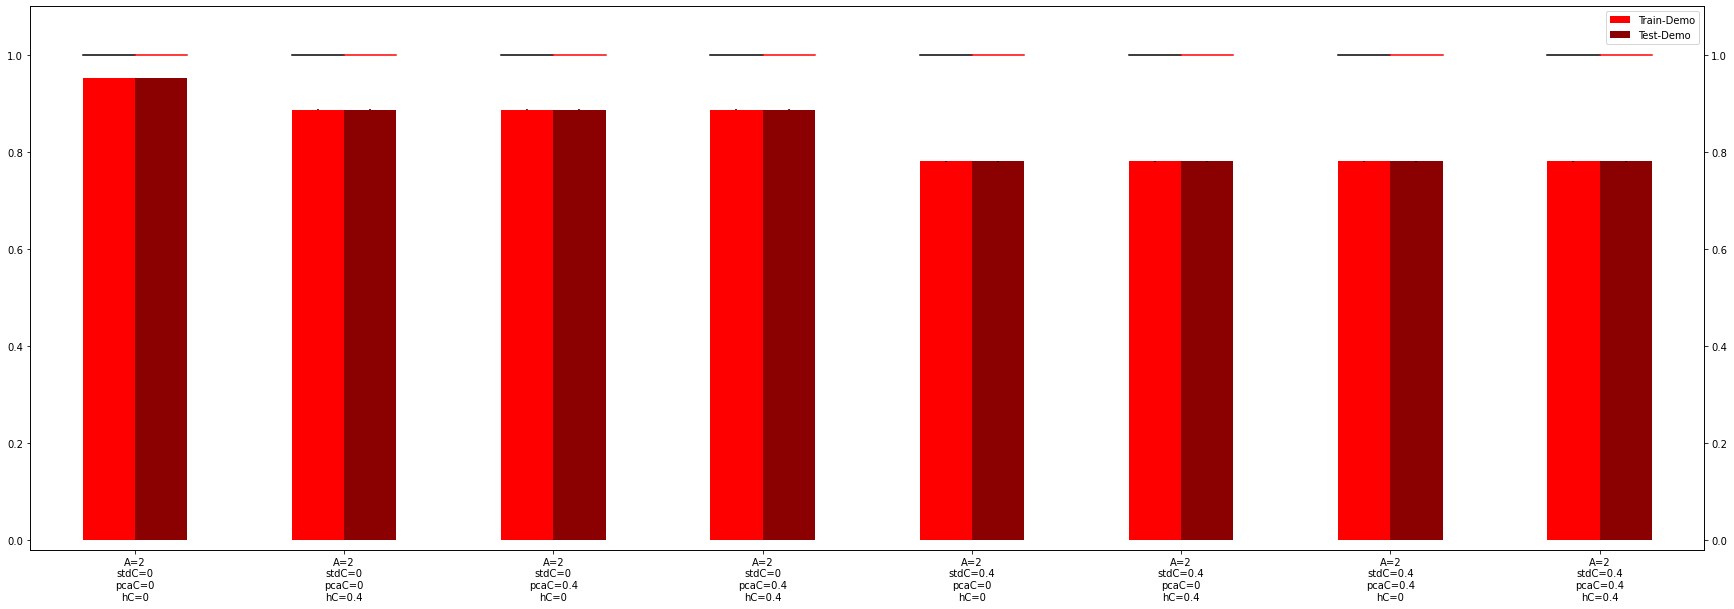

In [12]:
%%time

# prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, democracy_proportional, indexes, True)
prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, democracy, indexes, True)

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "Demo")
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

max_possible = bestScorePossible(prediction_per_rules_count)
print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : LaunchedProcess n°4 : Launched

Process n°5 : LaunchedProcess n°6 : Launched

Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Process n°0 : Finished
Process n°8 : Finished
Process n°4 : Finished
Process n°6 : Finished
Process n°5 : Finished
Process n°1 : Finished
Process n°10 : Finished
Process n°3 : Finished
Value('d', 20)
Process n°11 : Finished
Process n°12 : Finished
Process n°7 : Finished
Process n°9 : Finished
Process n°2 : Finished
24
CPU times: user 5.66 s, sys: 8.06 s, total: 13.7 s
Wall time: 42.1 s


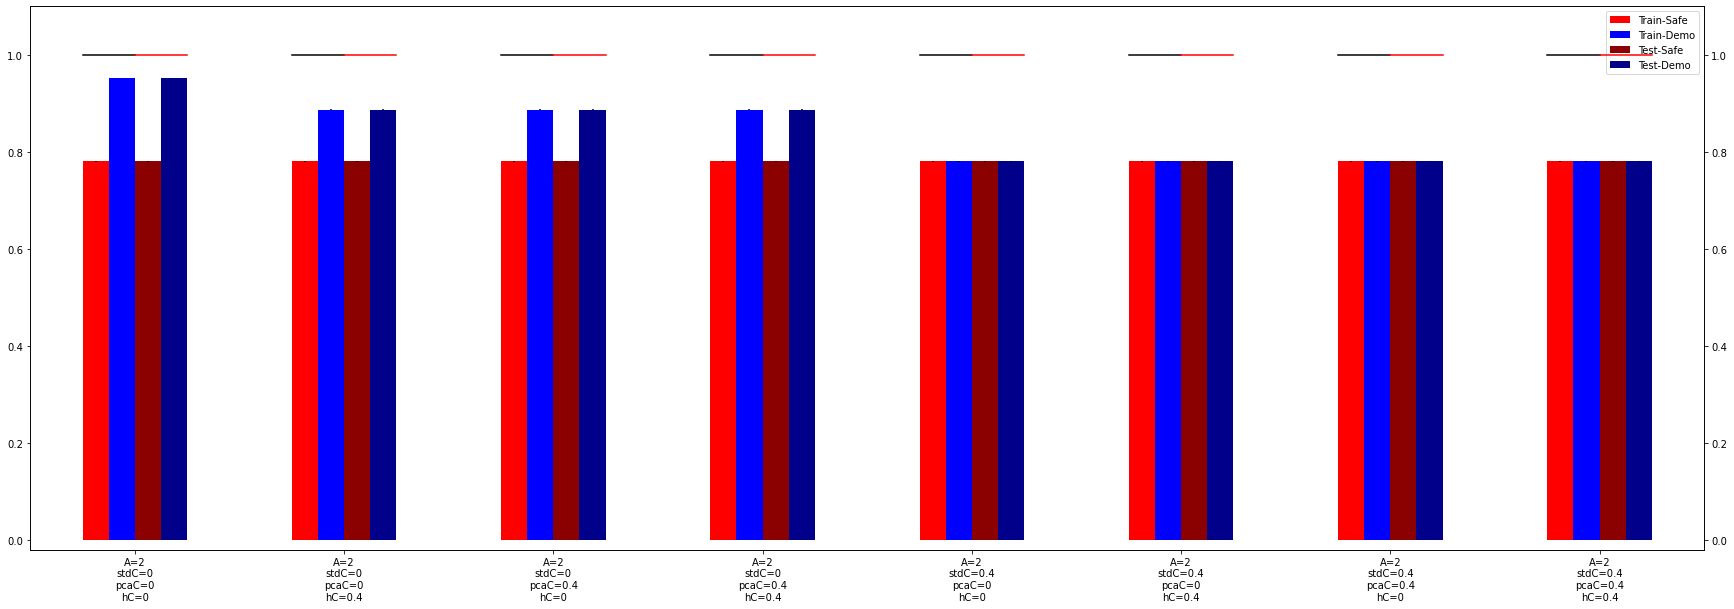

In [13]:
%%time

# prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, democracy, indexes, True)
prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, safe, indexes, True)

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "Safe")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : LaunchedProcess n°9 : Launched

Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Process n°8 : Finished
Process n°0 : Finished
Process n°9 : Finished
Process n°11 : Finished
Process n°2 : Finished
Process n°10 : Finished
Process n°3 : Finished
Process n°12 : Finished
Value('d', 20)
Process n°5 : Finished
Process n°4 : Finished
Process n°7 : Finished
Process n°6 : Finished
Process n°1 : Finished
24
CPU times: user 5.58 s, sys: 8.17 s, total: 13.8 s
Wall time: 2min 5s


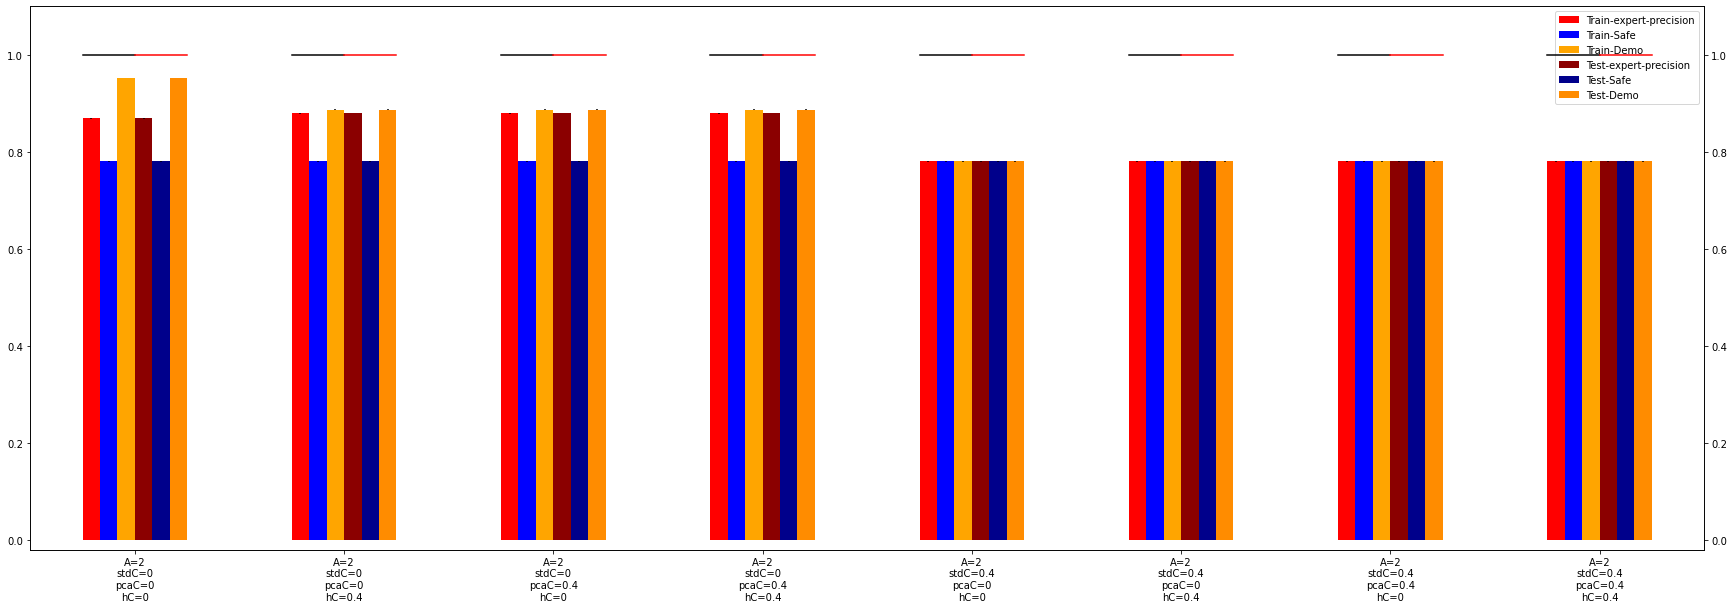

In [14]:
%%time

prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["precision_train", "precision_test"], [False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-precision")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Process n°11 : Finished
Process n°10 : Finished
Process n°4 : Finished
Process n°0 : Finished
Process n°8 : Finished
Process n°5 : Finished
Process n°2 : Finished
Process n°1 : Finished
Value('d', 20)
Process n°6 : Finished
Process n°3 : Finished
Process n°9 : Finished
Process n°7 : Finished
Process n°12 : Finished
24
CPU times: user 6.02 s, sys: 8.59 s, total: 14.6 s
Wall time: 1min 43s


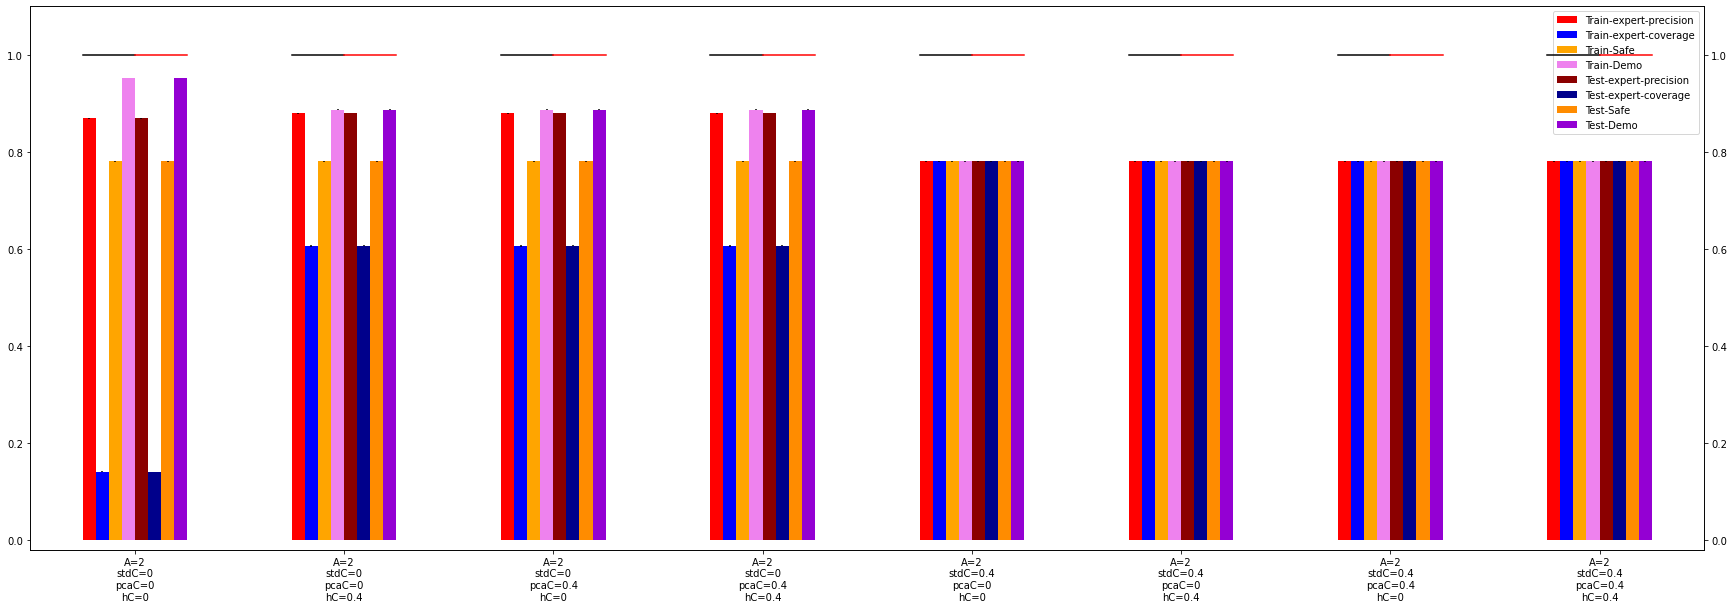

In [15]:
%%time

prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["headCoverage", "precision_train", "precision_test"], [True, False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-coverage")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : LaunchedProcess n°2 : LaunchedProcess n°4 : Launched

Process n°1 : LaunchedProcess n°3 : Launched


Process n°5 : LaunchedProcess n°6 : LaunchedProcess n°7 : LaunchedProcess n°8 : Launched



Process n°10 : LaunchedProcess n°9 : Launched

Process n°11 : LaunchedProcess n°12 : Launched

Value('d', 10)
Process n°0 : Finished
Process n°8 : Finished
Process n°5 : Finished
Process n°3 : Finished
Process n°9 : Finished
Process n°2 : FinishedProcess n°12 : Finished

Process n°4 : FinishedValue('d', 20)

Process n°7 : Finished
Process n°6 : Finished
Process n°1 : Finished
Process n°11 : Finished
Process n°10 : Finished
24
CPU times: user 5.69 s, sys: 8.19 s, total: 13.9 s
Wall time: 3min 2s


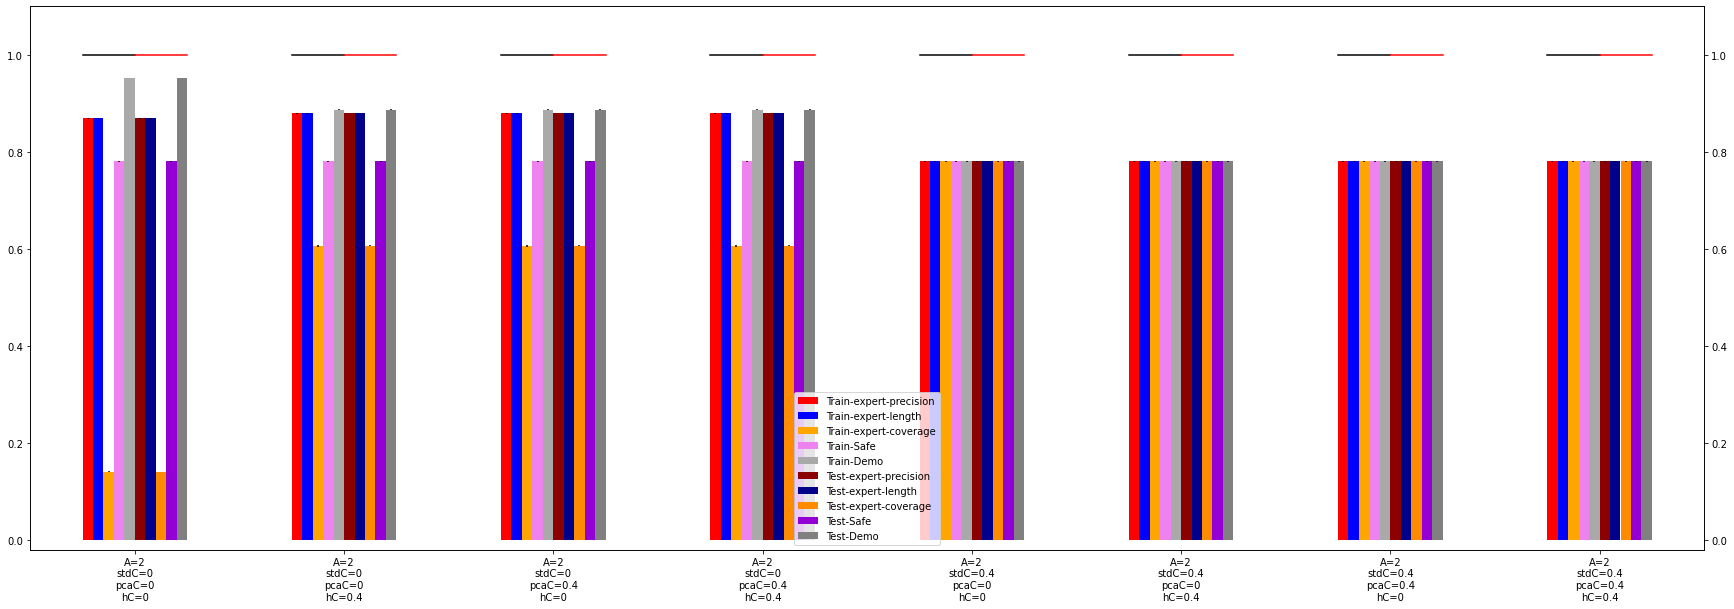

In [16]:
%%time

prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["size_hypothese", "precision_train", "precision_test"], [False, False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-length")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

In [18]:
new_dfs["CV=0-A=2\nstdC=0.4\npcaC=0\nhC=0"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, ?a loanAmount-LTE-50 ?b => ?a approval-False ?b to ?a income-GTE-75 ?b => ?a approval-False ?b
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hypotheses       19 non-null     object 
 1   conclusion       19 non-null     object 
 2   size_hypothese   19 non-null     int64  
 3   headCoverage     19 non-null     float64
 4   stdConfidence    19 non-null     float64
 5   pcaConfidence    19 non-null     float64
 6   precision_train  19 non-null     float64
 7   precision_test   19 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.3+ KB


In [19]:
new_dfs["CV=0-A=2\nstdC=0\npcaC=0.4\nhC=0"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, ?a income-GTE-75 ?b => ?a approval-True ?b to ?a monthDuration-LTE-75 ?b => ?a approval-True ?b
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hypotheses       49 non-null     object 
 1   conclusion       49 non-null     object 
 2   size_hypothese   49 non-null     int64  
 3   headCoverage     49 non-null     float64
 4   stdConfidence    49 non-null     float64
 5   pcaConfidence    49 non-null     float64
 6   precision_train  49 non-null     float64
 7   precision_test   49 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.4+ KB


In [20]:
new_dfs["CV=0-A=2\nstdC=0.4\npcaC=0\nhC=0"]

,hypotheses,conclusion,size_hypothese,headCoverage,stdConfidence,pcaConfidence,precision_train,precision_test
?a loanAmount-LTE-50 ?b => ?a approval-False ?b,"(?a loanAmount-LTE-50 ?b,)",?a approval-False ?b,1,0.638835,0.498335,0.638835,1.000000,1.000000
?a rate-LTE-25 ?b => ?a approval-False ?b,"(?a rate-LTE-25 ?b,)",?a approval-False ?b,1,0.753807,0.588021,0.753807,0.784601,0.785158
?a rate-GTE-75 ?b => ?a approval-False ?b,"(?a rate-GTE-75 ?b,)",?a approval-False ?b,1,0.747731,0.583281,0.747731,0.777109,0.778023
?a creditScore-GTE-75 ?b => ?a approval-False ?b,"(?a creditScore-GTE-75 ?b,)",?a approval-False ?b,1,0.748519,0.583896,0.748519,0.780346,0.783498
?a income-LTE-25 ?b => ?a approval-False ?b,"(?a income-LTE-25 ?b,)",?a approval-False ?b,1,0.697600,0.544175,0.697600,0.725691,0.728378
?a creditScore-LTE-25 ?b => ?a approval-False ?b,"(?a creditScore-LTE-25 ?b,)",?a approval-False ?b,1,0.749250,0.584466,0.749250,0.780294,0.782002
?a income-GTE-50 ?b => ?a approval-False ?b,"(?a income-GTE-50 ?b,)",?a approval-False ?b,1,0.567860,0.442969,0.567860,0.885540,0.883738
?a loanAmount-GTE-75 ?b => ?a approval-False ?b,"(?a loanAmount-GTE-75 ?b,)",?a approval-False ?b,1,0.681409,0.531545,0.681409,0.707334,0.707172
?a yearlyReimbursement-GTE-75 ?b => ?a approval-False ?b,"(?a yearlyReimbursement-GTE-75 ?b,)",?a approval-False ?b,1,0.680813,0.531080,0.680813,0.707152,0.707536
?a monthDuration-GTE-75 ?b => ?a approval-False ?b,"(?a monthDuration-GTE-75 ?b,)",?a approval-False ?b,1,0.778825,0.607536,0.778825,0.811322,0.814118


In [21]:
new_dfs["CV=0-A=2\nstdC=0\npcaC=0.4\nhC=0"]

,hypotheses,conclusion,size_hypothese,headCoverage,stdConfidence,pcaConfidence,precision_train,precision_test
?a income-GTE-75 ?b => ?a approval-True ?b,"(?a income-GTE-75 ?b,)",?a approval-True ?b,1,0.419452,0.092251,0.419452,0.367120,0.364937
?a loanAmount-LTE-50 ?b => ?a approval-False ?b,"(?a loanAmount-LTE-50 ?b,)",?a approval-False ?b,1,0.638835,0.498335,0.638835,1.000000,1.000000
?a income/yearlyReimbursement-GTE-50 ?b => ?a approval-True ?b,"(?a income/yearlyReimbursement-GTE-50 ?b,)",?a approval-True ?b,1,1.000000,0.219932,1.000000,0.437646,0.437616
?a loanAmount-LTE-25 ?b => ?a approval-True ?b,"(?a loanAmount-LTE-25 ?b,)",?a approval-True ?b,1,0.737144,0.162122,0.737144,0.647341,0.647278
?a creditScore-GTE-50 ?b => ?a approval-False ?b,"(?a creditScore-GTE-50 ?b,)",?a approval-False ?b,1,0.498192,0.388624,0.498192,0.779680,0.782492
?a rate-LTE-25 ?b => ?a approval-False ?b,"(?a rate-LTE-25 ?b,)",?a approval-False ?b,1,0.753807,0.588021,0.753807,0.784601,0.785158
?a rate-GTE-75 ?b => ?a approval-False ?b,"(?a rate-GTE-75 ?b,)",?a approval-False ?b,1,0.747731,0.583281,0.747731,0.777109,0.778023
?a loanAmount-LTE-50 ?b => ?a approval-True ?b,"(?a loanAmount-LTE-50 ?b,)",?a approval-True ?b,1,1.000000,0.219932,1.000000,0.438404,0.440418
?a loanAmount-LTE-75 ?b => ?a approval-True ?b,"(?a loanAmount-LTE-75 ?b,)",?a approval-True ?b,1,1.000000,0.219932,1.000000,0.292666,0.292828
?a creditScore-GTE-75 ?b => ?a approval-False ?b,"(?a creditScore-GTE-75 ?b,)",?a approval-False ?b,1,0.748519,0.583896,0.748519,0.780346,0.783498
